# Urban Parks & Demographics

In [1]:
#| echo: true 
#| code-fold: true
#Data Collection
#Methods to analyze
#results 

In [2]:
#| echo: true 
#| code-fold: true
#imports
import seaborn as sns 
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import altair as alt
import geopandas as gpd
import json
import folium
import pygris
import cenpy
import re
import copy
import warnings
import holoviews as hv
import hvplot.pandas 
from holoviews import opts
hv.extension('bokeh')
import ipywidgets as widgets
from ipywidgets import interact
from scipy.stats import pearsonr
# Suppress all warnings
warnings.filterwarnings('ignore')
from folium import Map, Marker
from IPython.display import IFrame

In [3]:
#| echo: true 
#| code-fold: true
#Check Parks
#read shape file 
shape_file_loc =  'parks_map/geo_export_46a7de00-0067-42f5-a6bc-bec64e5a0f0b.shp'

#convert it into geopanda dataframe 
def get_gpd_df(use_shape_file=True):
    if use_shape_file:
        gdf = gpd.read_file(shape_file_loc)
    return gdf
parks_gpd =  get_gpd_df()

#plot the map 
park_map = parks_gpd.explore(
    tiles="Cartodb positron",
        style_kwds={
        "weight": 2,
        "color": "green",
        "fillOpacity": 0.5,
        }
)
folium.TileLayer(opacity=0.20).add_to(park_map)
#create api conncection
ny_state_code = "36"
variables = ['NAME', 'B16008_002E' #Native population
             , 'B16008_019E' #Foreign-born population
             , 'B25064_001E' , #median_rent
             'B19013_001E'] #median_income
acs = cenpy.remote.APIConnection("ACSDT5Y2021")
NY_demo_data2021 = acs.query(
    cols=variables,
    geo_unit="tract:*",
    geo_filter={"state": ny_state_code,  "county":  "*"},
)
acs2 = cenpy.remote.APIConnection("ACSDT5Y2010")
NY_demo_data2010 = acs2.query(
    cols=variables,
    geo_unit="tract:*",
    geo_filter={"state": ny_state_code, "county": "*"},
)

NY_demo_data2010.dropna(inplace=True)
NY_demo_data2021.dropna(inplace=True)

#"061" Manhattan (New York County) 005 #Bronx 081 Queen  047  Brooklyn (Kings County) 085 Staten Island (Richmond County)
ny_city_counties = ["061" , "005" , "081", "047", "085"]

NY_demo_data2010 = NY_demo_data2010[NY_demo_data2010['county'].isin(ny_city_counties)]


for variable in variables:
    if variable != "NAME":
        NY_demo_data2010[variable] = NY_demo_data2010[variable].astype(float)

for variable in variables:
    if variable != "NAME":
        NY_demo_data2021[variable] = NY_demo_data2021[variable].astype(float)
        
NY_demo_data2010['population2010'] = NY_demo_data2010['B16008_002E'] + NY_demo_data2010['B16008_019E']
NY_demo_data2010 = NY_demo_data2010.rename(columns={'B19013_001E': 'median_income2010' ,'B25064_001E': 'median_rent2010'})
NY_demo_data2010 = NY_demo_data2010[NY_demo_data2010['population2010']>0]
NY_demo_data2010 = NY_demo_data2010[NY_demo_data2010['median_income2010']>=0]

NY_demo_data2021['population2021'] = NY_demo_data2021['B16008_002E'] + NY_demo_data2021['B16008_019E']
NY_demo_data2021 = NY_demo_data2021.rename(columns={'B19013_001E': 'median_income2021' ,'B25064_001E': 'median_rent2021'})
NY_demo_data2021 = NY_demo_data2021[NY_demo_data2021['population2021']>0]
NY_demo_data2021 = NY_demo_data2021[NY_demo_data2021['median_income2021']>=0]


population_total_df = pd.merge(NY_demo_data2010, NY_demo_data2021 , on=['tract','county','NAME']) 

population_total_df['change_precent'] = ((population_total_df['population2021'] - population_total_df['population2010']) /(np.absolute(population_total_df['population2010'])))*100

shape_file_loc =  'census_tract_shapefile/tl_2021_36_tract.shp'
#convert it into geopanda dataframe 
def get_gpd_df(use_shape_file=True):
    if use_shape_file:
        gdf = gpd.read_file(shape_file_loc)
    return gdf
nyc_gpd =  get_gpd_df()

nyc_demo_merged = nyc_gpd.merge(
    population_total_df,
    left_on=["STATEFP", "COUNTYFP", "TRACTCE"],
    right_on=["state_x", "county", "tract"],)

nyc_pct_change_mean = nyc_demo_merged['change_precent'].mean()

nyc_demo_merged = nyc_demo_merged[['tract', 'geometry', 'population2010','population2021','change_precent'
                                  ,'median_income2010' , 'median_income2021',
                                  'median_rent2010','median_rent2021']]
nyc_demo_merged = nyc_demo_merged[nyc_demo_merged['change_precent'] < 300]


In [4]:
#| echo: true 
#| code-fold: true
def style(feature):
    return {
        'fillColor': 'green',  
        'color': 'black',      
        'weight': 2,          
        'fillOpacity': 0.6    
    }
def mapping(df,col,parks_gpd=parks_gpd):

    m = df.explore(column=col,cmap = 'Blues', 
                                tiles="CartoDB positron", zoom_start=11)
    folium.Marker(location=[40.747993, -74.004890], popup="The High Line" , icon=folium.Icon(icon='tree' ,color='red')).add_to(m)
    folium.Marker(location=[40.785091, -73.968285], popup="Central Park" , icon=folium.Icon(icon='tree' ,color='red')).add_to(m)
    folium.Marker(location=[40.665535, -73.969749], popup="Prospect Park" , icon=folium.Icon(icon='tree' ,color='red')).add_to(m)
    folium.Marker(location=[40.699215, -73.999039], popup="Brooklyn Bridge Park" , icon=folium.Icon(icon='tree' ,color='red')).add_to(m)
    folium.Marker(location=[40.739716, -73.840782], popup="Flushing Meadows Corona Park" , icon=folium.Icon(icon='tree' ,color='red')).add_to(m)
    folium.Marker(location=[40.703564, -74.016678], popup="Battery Park" , icon=folium.Icon(icon='tree' ,color='red')).add_to(m)

    folium.GeoJson(
        parks_gpd,
        name='geojson_layer',
        style_function=style
    ).add_to(m)
    
    return m 

# Do urban parks influence migration to nearby neighborhoods?

In [5]:
#| echo: true 
#| code-fold: true
m = mapping(nyc_demo_merged,"change_precent",parks_gpd=parks_gpd)
# Save the map as HTML
html_path = "map1.html"
m.save(html_path)
# Display the HTML file as an iframe
IFrame(html_path, width=800, height=600)

# Did neighborhoods nearby urban parks experience a decrease in population between Census 2010 and Census 2020?

In [6]:
#| echo: true 
#| code-fold: true
nyc_demo_merged_sub_loss = nyc_demo_merged[nyc_demo_merged['change_precent'] < 0]
m2 = mapping(nyc_demo_merged_sub_loss,"change_precent",parks_gpd=parks_gpd)
# Save the map as HTML
html_path = "map2.html"
m2.save(html_path)
# Display the HTML file as an iframe
IFrame(html_path, width=800, height=600)
#decreased 

# Does the variation in rental prices contribute to the population decline in areas experiencing a decrease?

In [7]:
#| echo: true 
#| code-fold: true
def compare(df, tracts , park_name):
    df.tract = df.tract.astype(str)
    df = df[df.tract.isin(tracts)]
    df = df[['median_income2010', 'median_income2021','median_rent2010' , 'median_rent2021']]
    mean = df.mean(axis=0).reset_index()
    mean = mean.rename(columns={
    'index': 'Variable',
    0: 'Values'})
    rent = mean[mean['Variable'].str.contains('rent')]
    income = mean[mean['Variable'].str.contains('income')]

    rent['Year'] = rent['Variable'].astype(str).str[-4:]
    income['Year'] = income['Variable'].astype(str).str[-4:]
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [1, 1]})
    sns.barplot(x='Year', y='Values', data=rent, palette='pastel', ax=axes[0])
    axes[0].set_xlabel('year')
    axes[0].set_ylabel('Median Rent')
    axes[0].set_title('Median Rent In ' + park_name + ' Area' , fontsize=10)
    sns.barplot(x='Year', y='Values', data=income, palette='pastel', ax=axes[1])
    axes[1].set_xlabel('year')
    axes[1].set_ylabel('Median Income')
    axes[1].set_title('Median Income  In ' + park_name + ' Area' , fontsize=10)
    plt.tight_layout()
    # Show the plots
    plt.show()

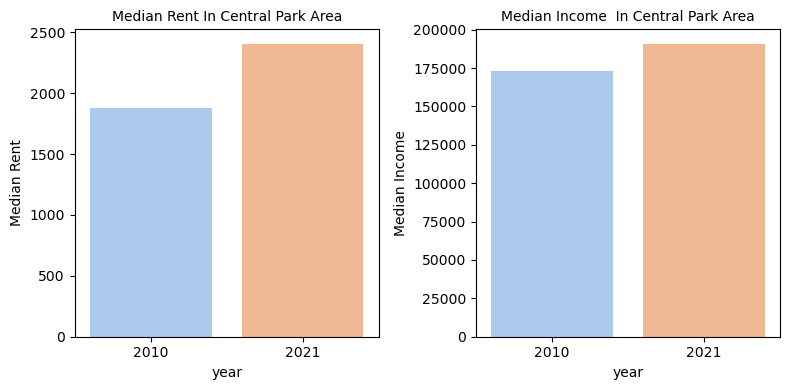

In [8]:
#| echo: true 
#| code-fold: true
central = ['013000' , '012000' , '015001' , '015002']
compare(nyc_demo_merged_sub_loss, central , 'Central Park')

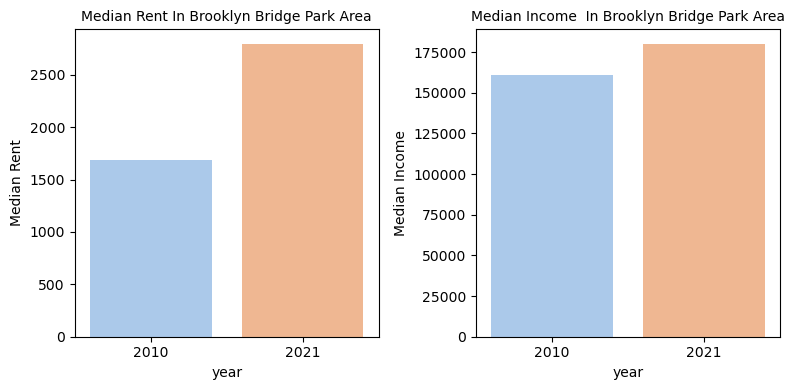

In [9]:
#| echo: true 
#| code-fold: true
brooklyn = [ '000301' ]
compare(nyc_demo_merged_sub_loss, brooklyn , 'Brooklyn Bridge Park')

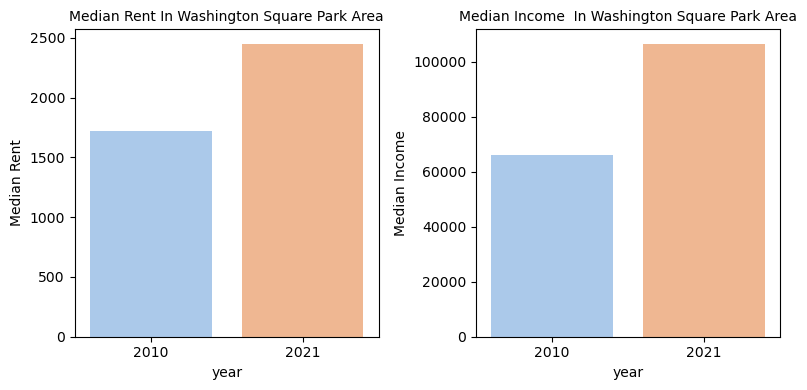

In [10]:
#| echo: true 
#| code-fold: true
wsqaure = [ '006500' ]
compare(nyc_demo_merged_sub_loss, wsqaure , 'Washington Square Park')

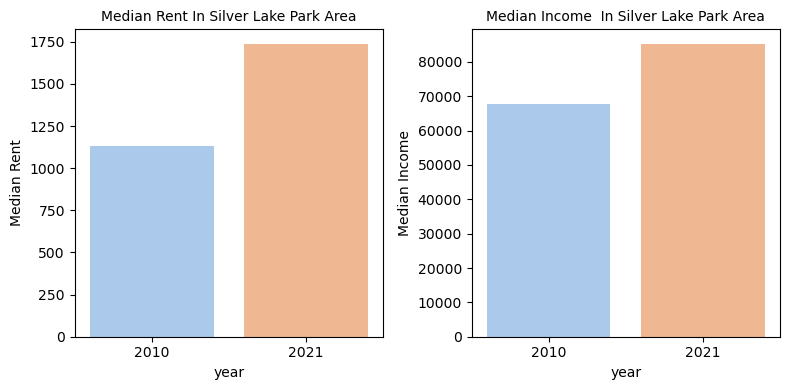

In [11]:
#| echo: true 
#| code-fold: true
wsqaure = [ '003900' ]
compare(nyc_demo_merged_sub_loss, wsqaure , 'Silver Lake Park')

# Is there a correlation between median income and the accessibility of parks?

In [12]:
#| echo: true 
#| code-fold: true
with open('indicators_data/2388.json', 'r') as file:
    park_walking_data = json.load(file)
    
park_walking_data = pd.DataFrame(park_walking_data)
park_walking_data = park_walking_data[park_walking_data.GeoType=="UHF42"]

shape_file_loc = 'UHF 42/UHF_42_DOHMH.shp'
#convert it into geopanda dataframe 
def get_gpd_df(use_shape_file=True):
    if use_shape_file:
        gdf = gpd.read_file(shape_file_loc)
    return gdf
uhf_gpd =  get_gpd_df()
uhf_gpd.to_crs(epsg = "4326", inplace = True)

merged_ny_walking = uhf_gpd.merge(
    park_walking_data,
    left_on=["UHF"],
    right_on=["GeoID"])

joined_data = gpd.sjoin(nyc_demo_merged, merged_ny_walking, how='left', op='within')
joined_data.dropna(inplace=True)

numerical_correlation, _ = pearsonr(joined_data['Value'], joined_data['median_income2010'])
print(f"Pearson's correlation coefficient: {numerical_correlation}")

numerical_correlation, _ = pearsonr(joined_data['Value'], joined_data['median_income2021'])
print(f"Pearson's correlation coefficient: {numerical_correlation}")

m = mapping(joined_data,"Value",parks_gpd=parks_gpd)
# Save the map as HTML
html_path = "map1.html"
m.save(html_path)
# Display the HTML file as an iframe
IFrame(html_path, width=800, height=600)

Pearson's correlation coefficient: -0.263688800485939
Pearson's correlation coefficient: -0.12378378631103196


# Is there a correlation  between the presence of families in nearby neighbourhoods and the availability of Children Playgrounds?

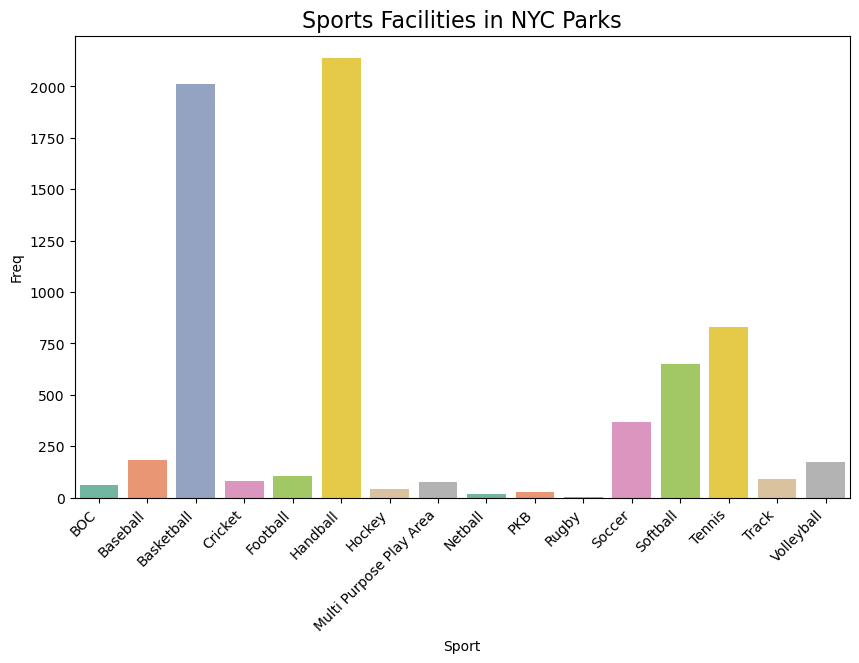

In [14]:
#| echo: true 
#| code-fold: true
shape_file_loc = 'CPA/geo_export_f2e1ecf0-ad20-4676-8b9d-ee96dfeef1bd.shp'

#convert it into geopanda dataframe 
def get_gpd_df(use_shape_file=True):
    if use_shape_file:
        gdf = gpd.read_file(shape_file_loc)
    return gdf
CPA_gpd =  get_gpd_df()


shape_file_loc = 'Athletic_Facilities/geo_export_35c572bd-a799-446c-890f-c78e4d293ea0.shp'

#convert it into geopanda dataframe 
def get_gpd_df(use_shape_file=True):
    if use_shape_file:
        gdf = gpd.read_file(shape_file_loc)
    return gdf
AF_gpd =  get_gpd_df()

#source https://docs.google.com/spreadsheets/d/1iIhwuLBlIus2n1EQ2a329jX4oJciXt9dEaxOFPpHfE8/edit?usp=sharing
sport_map = {
    'BKB': 'Basketball',
    'BSB': 'Baseball',
    'CRK': 'Cricket',
    'FFB': 'Flag Football',
    'FRS': 'Frisbee',
    'FTB': 'Football',
    'HDB': 'Handball',
    'HKY': 'Hockey',
    'KBL': 'Kickball',
    'LCS': 'Lacrosse',
    'MPPA': 'Multi Purpose Play Area',
    'NTB': 'Netball',
    'RBY': 'Rugby',
    'SCR': 'Soccer',
    'SFB': 'Softball',
    'TNS': 'Tennis',
    'TRK': 'Track',
    'VLB': 'Volleyball',
    'WFB': 'Wheelchair Football'
}

AF_gpd['primary_sp'] = AF_gpd['primary_sp'].replace(sport_map)
AF_count = AF_gpd.groupby('primary_sp').size().reset_index(name='Count')

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='primary_sp', y='Count', data=AF_count, palette='Set2')
ax.set_title('Sports Facilities in NYC Parks' , fontsize=16)
ax.set_xlabel('Sport')
ax.set_ylabel('Freq')
plt.xticks(rotation=45, ha='right');

In [15]:
#| echo: true 
#| code-fold: true
import folium
from folium.plugins import MarkerCluster

m = folium.Map(location=[40.747993, -74.004890] , tiles="Cartodb positron", zoom_start=10)
playgrounds_cluster = MarkerCluster(name='Children Play Area').add_to(m)
for idx, row in CPA_gpd.iterrows():
    folium.Marker(location=[row['geometry'].centroid.y, row['geometry'].centroid.x], popup=row['name']).add_to(playgrounds_cluster)

athletic_cluster = MarkerCluster(name='Athletic Facilities').add_to(m)
for idx, row in AF_gpd.iterrows():
    folium.Marker(location=[row['geometry'].centroid.y, row['geometry'].centroid.x] ,popup=row['primary_sp']).add_to(athletic_cluster)

folium.LayerControl().add_to(m)

html_path = "FA_CPA_Map.html"
m.save(html_path)
# Display the HTML file as an iframe
IFrame(html_path, width=800, height=600)



In [16]:
#| echo: true 
#| code-fold: true
vars_fam = ['NAME', 'B11012_003E', 'B11012_006E', 'B11012_010E','B11012_015E']

acs = cenpy.remote.APIConnection("ACSDT5Y2021")
NY_fam_data2021 = acs.query(
    cols=vars_fam,
    geo_unit="tract:*",
    geo_filter={"state": ny_state_code,  "county":  "*"},
)
NY_fam_data2021 = NY_fam_data2021[NY_fam_data2021['county'].isin(ny_city_counties)]
for variable in vars_fam:
    if variable != "NAME":
        NY_fam_data2021[variable] = NY_fam_data2021[variable].astype(float)
        
NY_fam_data2021['Total_Families'] = NY_fam_data2021[['B11012_003E', 'B11012_006E', 'B11012_010E','B11012_015E']].sum(axis=1)

nyc_fam_merged = nyc_gpd.merge(
    NY_fam_data2021,
    left_on=["STATEFP", "COUNTYFP", "TRACTCE"],
    right_on=["state", "county", "tract"],)

In [17]:
#| echo: true 
#| code-fold: true
joined_data2 = gpd.sjoin(CPA_gpd, nyc_fam_merged, how="inner", op="within")
joined_data2.drop_duplicates(subset=['location','county'], inplace=True)

playgrounds_per_tract = joined_data2.groupby(['tract', 'county']).size().reset_index(name='CPA_Count')
CPA_fam_count = nyc_fam_merged.merge(playgrounds_per_tract, how='left', left_on=['tract','county'], right_on=['tract','county'])
CPA_fam_count.dropna(inplace=True)
CPA_fam_count = CPA_fam_count[CPA_fam_count.Total_Families>0]

correlation_coefficient, p_value = pearsonr(CPA_fam_count['CPA_Count'], CPA_fam_count['Total_Families'])

correlation_coefficient

0.07816702466699046

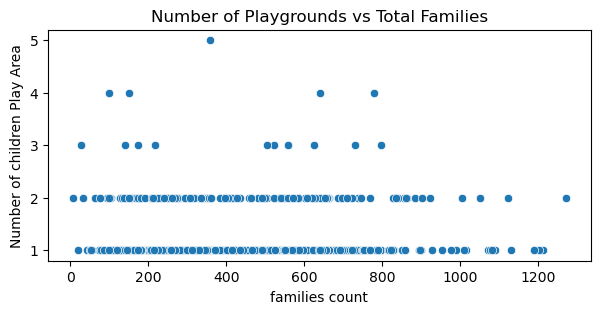

In [18]:
#| echo: true 
#| code-fold: true
%matplotlib inline
plt.figure(figsize=(7, 3))
sns.scatterplot(x='Total_Families', y='CPA_Count', data=CPA_fam_count)
plt.title('Number of Playgrounds vs Total Families')
plt.xlabel('families count')
plt.ylabel('Number of children Play Area')
plt.show()

# Is there a corrleation between regular exercise and the avaliability atheltic facilities at parks ? 

In [19]:
#| echo: true 
#| code-fold: true
with open('indicators_data/2060.json', 'r') as file:
    physical_activity_data = json.load(file)

physical_activity_data = pd.DataFrame(physical_activity_data)
physical_activity_data = physical_activity_data[physical_activity_data.GeoType=="UHF42"]
physical_activity_data.GeoID = physical_activity_data.GeoID.astype(float)

physical_activity_data = physical_activity_data[physical_activity_data.Time=='2019']
merged_ny_physical = uhf_gpd.merge(
    physical_activity_data,
    left_on=["UHF"],
    right_on=["GeoID"])

joined_gdf = gpd.sjoin(AF_gpd, merged_ny_physical, how='inner', op='intersects')

tract_aggregated = joined_gdf.groupby(['GeoID','borough' ])['system'].count().reset_index()

merged_data = pd.merge(tract_aggregated, physical_activity_data, on=['GeoID'])

correlation_coefficient, p_value = pearsonr(merged_data['system'], merged_data['Value'])
correlation_coefficient

-0.2820924647154564

# Is there a corrleation between exercise and accessibility of parks?

In [20]:
#| echo: true 
#| code-fold: true
#Physical Activity 
with open('indicators_data/2060.json', 'r') as file:
    physical_activity_data = json.load(file)
    
with open('indicators_data/2388.json', 'r') as file:
    park_walking_data = json.load(file)
    
#read shape file for UHF 42
shape_file_loc = 'UHF 42/UHF_42_DOHMH.shp'

#convert it into geopanda dataframe 
def get_gpd_df(use_shape_file=True):
    if use_shape_file:
        gdf = gpd.read_file(shape_file_loc)
    return gdf
uhf_gpd =  get_gpd_df()
uhf_gpd.to_crs(epsg = "4326", inplace = True)


physical_activity_data = pd.DataFrame(physical_activity_data)
physical_activity_data = physical_activity_data[physical_activity_data.GeoType=="UHF42"]
physical_activity_data.GeoID = physical_activity_data.GeoID.astype(float)
merged_ny_physical = uhf_gpd.merge(
    physical_activity_data,
    left_on=["UHF"],
    right_on=["GeoID"])

plot = merged_ny_physical.hvplot(
    c="Value",
    groupby="Time",
    frame_width=600,
    frame_height=600,
    geo=True,
    dynamic=False,
    cmap="Greens",
    hover_cols=["GEOID"]
)
plot.opts(title='Recent Exercise in NY by Neighbourhood')


:HoloMap   [Time]
   :Polygons   [Longitude,Latitude]   (Value)

In [21]:
#| echo: true 
#| code-fold: true

#ref:
#https://a816-dohbesp.nyc.gov/IndicatorPublic/data-explorer/physical-activity/?id=2060

park_walking_data = pd.DataFrame(park_walking_data)
park_walking_data = park_walking_data[park_walking_data.GeoType=="UHF42"]

physical_activity_data = physical_activity_data[physical_activity_data.Time=='2017']

merged_ny_walking = uhf_gpd.merge(
    park_walking_data,
    left_on=["UHF"],
    right_on=["GeoID"])

plot = merged_ny_walking.hvplot(
    c="Value",
    groupby="Time",
    frame_width=600,
    frame_height=600,
    geo=True,
    dynamic=False,
    cmap="Greens",
    hover_cols=["GEOID"]
)
plot.opts(title='Walking Distance to a Park in NY by Neighbourhood in 2017')

:HoloMap   [Time]
   :Polygons   [Longitude,Latitude]   (Value)

In [22]:
#| echo: true 
#| code-fold: true
merged_walking_corr = physical_activity_data.merge(
    park_walking_data, on=['GeoID', 'Time'])
correlation_coefficient, p_value = pearsonr(merged_walking_corr.Value_x,merged_walking_corr.Value_y)
correlation_coefficient

0.28957159180561953

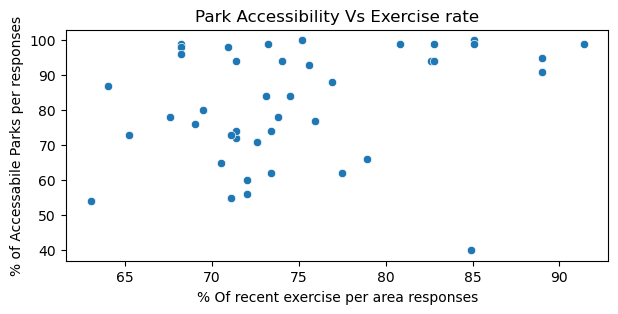

In [23]:
#| echo: true 
#| code-fold: true
plt.figure(figsize=(7, 3))
sns.scatterplot(x='Value_x', y='Value_y', data=merged_walking_corr)
plt.title('Park Accessibility Vs Exercise rate')
plt.xlabel('% Of recent exercise per area responses')
plt.ylabel('% of Accessabile Parks per responses')
plt.show()